In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


Початок аналізу конверсії...
Завантажено 62874 записів

 Структура даних:
Розмір: (62874, 6)
Колонки: ['user_id', 'product_id', 'refunded', 'purchase_date', 'country_code', 'media_source']


,user_id,product_id,refunded,purchase_date,country_code,media_source
0,2589061,tenwords_1w_7.99_7free,False,2020-09-27,JO,Facebook Ads
1,2604470,tenwords_1w_9.99_offer,False,2020-09-29,UK,Facebook Ads
2,2274467,tenwords_1w_9.99_offer,False,2020-08-18,Organic/Unknown,Organic/Unknown
3,2488755,tenwords_lifetime_limited_49.99,False,2020-09-14,PE,Facebook Ads
4,2571294,tenwords_1w_9.99_offer,False,2020-09-25,US,Google Ads



 Кількість транзакцій для tenwords_1w_9.99_offer: 43613
 Успішні транзакції: 41799
 Відмінені транзакції: 1814

 Період даних: з 2020-07-01 по 2020-09-30

 РЕезультати аналізу конверсії
 Загальна кількість користувачів з першим платежем (тріал): 18,014
 Кількість користувачів з успішним другим платежем: 7,160
 Конверсія з тріалу у другий платіж: 39.75%

 Додаткова статистика:
 Користувачі з 2+ платежами: 7,587
 Відсоток користувачів, які зробили 2+ платежі: 42.12%

 Топ-10 країн за кількістю користувачів:


,total_users,converted_users,conversion_rate
country_code,,,
US,6707,2871,42.81
Organic/Unknown,1854,755,40.72
RU,708,255,36.02
CA,587,211,35.95
BR,458,216,47.16
UK,390,131,33.59
HK,321,107,33.33
MX,319,115,36.05
PL,304,105,34.54



 Аналіз по джерелах трафіку:


,total_users,converted_users,conversion_rate
media_source,,,
Facebook Ads,14133,5706,40.37
Organic/Unknown,1882,764,40.60
Google Ads,1661,530,31.91
ByteDance,338,160,47.34



 Створення візуалізацій...


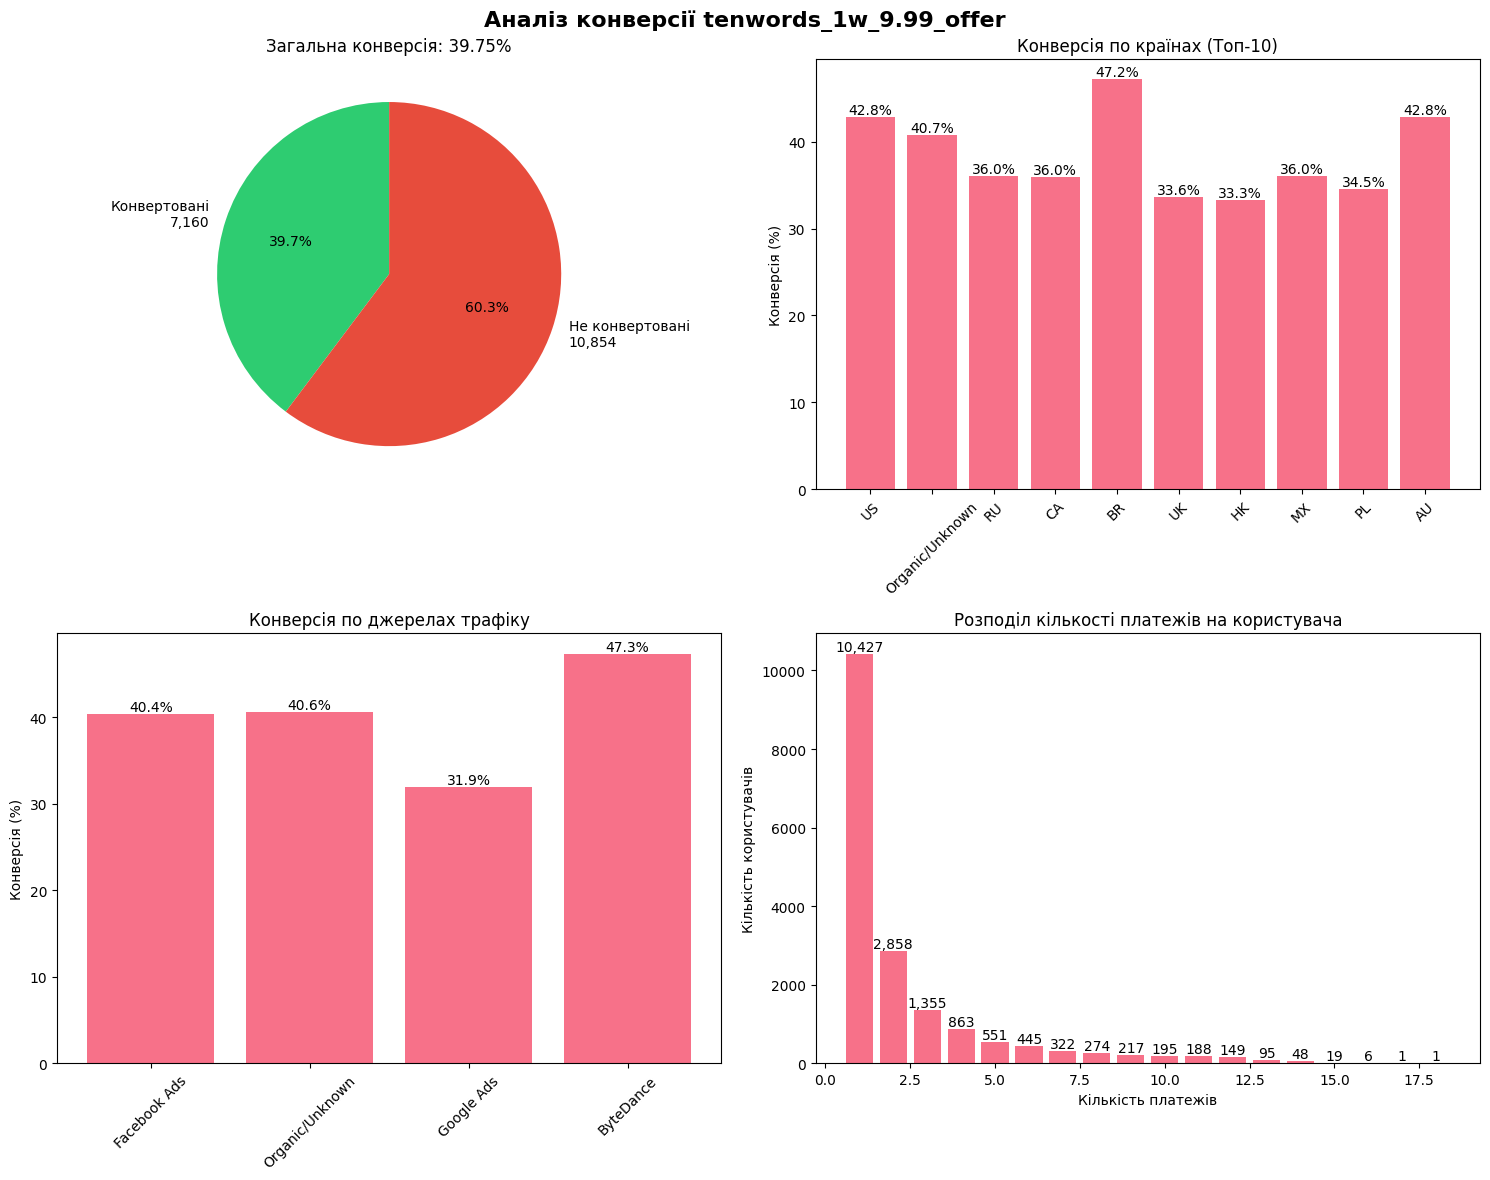


 Аналіз завершено!
 Основний результат: Конверсія з тріалу у другий платіж становить 39.75%


In [5]:
plt.style.use('default')
sns.set_palette("husl")

def analyze_trial_to_second_payment_conversion(file_path):
    """
    Analyzes user conversion from trial period to second payment for subscription tenwords_1w_9.99_offer
    """
    # Loading data
    try:
        df = pd.read_csv(file_path)
        print(f"Завантажено {len(df)} записів")
    except Exception as e:
        print(f"Помилка завантаження файлу: {e}")
        return None
    
    # Show the data structure
    print(f"\n Структура даних:")
    print(f"Розмір: {df.shape}")
    print(f"Колонки: {list(df.columns)}")
    
    display(df.head())
    
    # Filter only the subscription tenwords_1w_9.99_offer
    df_filtered = df[df['product_id'] == 'tenwords_1w_9.99_offer'].copy()
    print(f"\n Кількість транзакцій для tenwords_1w_9.99_offer: {len(df_filtered)}")
    
    # Process the refunded column
    if df_filtered['refunded'].dtype == 'object':
        # Convert text values ​​to boolean
        refund_mapping = {
            'ИСТИНА': True, 'истина': True, 'True': True, 'TRUE': True, True: True,
            'ЛОЖЬ': False, 'ложь': False, 'False': False, 'FALSE': False, False: False
        }
        df_filtered['refunded'] = df_filtered['refunded'].map(refund_mapping)
        print("Конвертовано колонку 'refunded' в булевий тип")
    
    print(f" Успішні транзакції: {len(df_filtered) - df_filtered['refunded'].sum()}")
    print(f" Відмінені транзакції: {df_filtered['refunded'].sum()}")
    
    # convert the date to datetime format
    df_filtered['purchase_date'] = pd.to_datetime(df_filtered['purchase_date'])
    
    # Sort by user_id and purchase date
    df_filtered = df_filtered.sort_values(['user_id', 'purchase_date'])
    
    print(f"\n Період даних: з {df_filtered['purchase_date'].min().date()} по {df_filtered['purchase_date'].max().date()}")
    
    # analyze the conversion from trial to second payment
    trial_users = 0  # users  made first payment 
    converted_users = 0  # successful second payment
    
    conversion_details = []
    
    for user_id in df_filtered['user_id'].unique():
        user_payments = df_filtered[df_filtered['user_id'] == user_id].sort_values('purchase_date')
        
        if len(user_payments) >= 1:
            # First payment = trial period
            trial_users += 1
            first_payment = user_payments.iloc[0]
            
            user_detail = {
                'user_id': user_id,
                'first_payment_date': first_payment['purchase_date'],
                'first_payment_refunded': first_payment['refunded'],
                'total_payments': len(user_payments),
                'has_second_payment': len(user_payments) >= 2,
                'second_payment_successful': False,
                'country_code': first_payment['country_code'],
                'media_source': first_payment['media_source']
            }
            
            # Checking the second payment
            if len(user_payments) >= 2:
                second_payment = user_payments.iloc[1]
                user_detail['second_payment_date'] = second_payment['purchase_date']
                user_detail['second_payment_refunded'] = second_payment['refunded']
                
                if not second_payment['refunded']:
                    user_detail['second_payment_successful'] = True
                    converted_users += 1
            
            conversion_details.append(user_detail)
    
    # Conversion calculation
    conversion_rate = (converted_users / trial_users) * 100 if trial_users > 0 else 0
    
    # Create a DataFrame with detailed information
    conversion_df = pd.DataFrame(conversion_details)
    
    # results
    print(f"\n{'='*60}")
    print(" РЕезультати аналізу конверсії")
    print(f"{'='*60}")
    print(f" Загальна кількість користувачів з першим платежем (тріал): {trial_users:,}")
    print(f" Кількість користувачів з успішним другим платежем: {converted_users:,}")
    print(f" Конверсія з тріалу у другий платіж: {conversion_rate:.2f}%")
    
    users_with_multiple_payments = len([u for u in conversion_details if u['total_payments'] >= 2])
    print(f"\n Додаткова статистика:")
    print(f" Користувачі з 2+ платежами: {users_with_multiple_payments:,}")
    print(f" Відсоток користувачів, які зробили 2+ платежі: {(users_with_multiple_payments/trial_users)*100:.2f}%")
    
    # Analysis by country
    country_conversion = conversion_df.groupby('country_code').agg({
        'user_id': 'count',
        'second_payment_successful': 'sum'
    }).rename(columns={'user_id': 'total_users', 'second_payment_successful': 'converted_users'})
    
    country_conversion['conversion_rate'] = (country_conversion['converted_users'] / 
                                           country_conversion['total_users'] * 100).round(2)
    country_conversion = country_conversion.sort_values('total_users', ascending=False)
    
    print(f"\n Топ-10 країн за кількістю користувачів:")
    display(country_conversion.head(10))
    
    # Analysis by traffic sources
    source_conversion = conversion_df.groupby('media_source').agg({
        'user_id': 'count',
        'second_payment_successful': 'sum'
    }).rename(columns={'user_id': 'total_users', 'second_payment_successful': 'converted_users'})
    
    source_conversion['conversion_rate'] = (source_conversion['converted_users'] / 
                                          source_conversion['total_users'] * 100).round(2)
    source_conversion = source_conversion.sort_values('total_users', ascending=False)
    
    print(f"\n Аналіз по джерелах трафіку:")
    display(source_conversion)
    
    return {
        'conversion_rate': conversion_rate,
        'trial_users': trial_users,
        'converted_users': converted_users,
        'conversion_details': conversion_df,
        'country_analysis': country_conversion,
        'source_analysis': source_conversion,
        'raw_data': df_filtered
    }

def create_conversion_visualizations(results):
    """
    Creates visualizations of conversion analysis results
    """
    if not results:
        print(" Немає даних для візуалізації")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Аналіз конверсії tenwords_1w_9.99_offer', fontsize=16, fontweight='bold')
    
    #  Total conversion
    ax1 = axes[0, 0]
    sizes = [results['converted_users'], results['trial_users'] - results['converted_users']]
    labels = [f'Конвертовані\n{results["converted_users"]:,}', 
              f'Не конвертовані\n{results["trial_users"] - results["converted_users"]:,}']
    colors = ['#2ecc71', '#e74c3c']
    
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    ax1.set_title(f'Загальна конверсія: {results["conversion_rate"]:.2f}%')
    
    #  Top countries by conversion
    ax2 = axes[0, 1]
    top_countries = results['country_analysis'].head(10)
    if not top_countries.empty:
        bars = ax2.bar(range(len(top_countries)), top_countries['conversion_rate'])
        ax2.set_xticks(range(len(top_countries)))
        ax2.set_xticklabels(top_countries.index, rotation=45)
        ax2.set_ylabel('Конверсія (%)')
        ax2.set_title('Конверсія по країнах (Топ-10)')
        
        # Add values ​​to columns
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom')
    
    # Traffic sources
    ax3 = axes[1, 0]
    source_data = results['source_analysis'].head(5)
    if not source_data.empty:
        bars = ax3.bar(range(len(source_data)), source_data['conversion_rate'])
        ax3.set_xticks(range(len(source_data)))
        ax3.set_xticklabels(source_data.index, rotation=45)
        ax3.set_ylabel('Конверсія (%)')
        ax3.set_title('Конверсія по джерелах трафіку')
        
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom')
    
    #  Distribution of the number of payments
    ax4 = axes[1, 1]
    payment_counts = results['conversion_details']['total_payments'].value_counts().sort_index()
    bars = ax4.bar(payment_counts.index, payment_counts.values)
    ax4.set_xlabel('Кількість платежів')
    ax4.set_ylabel('Кількість користувачів')
    ax4.set_title('Розподіл кількості платежів на користувача')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Main function to run analysis
def run_conversion_analysis(file_path):
    """
    Runs full conversion analysis with visualization
    """
    print("Початок аналізу конверсії...")
    
    # Performing the analysis
    results = analyze_trial_to_second_payment_conversion(file_path)
    
    if results:
        # visualizations
        print("\n Створення візуалізацій...")
        create_conversion_visualizations(results)
        
        print(f"\n Аналіз завершено!")
        print(f" Основний результат: Конверсія з тріалу у другий платіж становить {results['conversion_rate']:.2f}%")
        
        return results
    else:
        print(" Аналіз не вдався")
        return None
results = run_conversion_analysis('Product_analyst.csv')